In [1]:
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import torch
from controller import Controller
from torch.utils import data
import matplotlib.pyplot as plt
import pickle as pkl
import math
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

In [2]:
class Dataset(data.Dataset):
    """
    Class to transfer Sk-learn dataset to tensors for Pytorch
    """
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Define lambda function to return rotation matrix with angle X degree (2D Space)
rotate_matrix = lambda x: np.array([[math.cos(x), -math.sin(x)], 
                                    [math.sin(x), math.cos(x)]])

In [4]:
def load_dataset(dataset_name='moon' ,p_val=0.1, p_test=0.2, noise=0.2, rotate_angle=0):
    """
    Handle dataset and return it
    
    :param: p_val:
            p_test:
            noise: variance of the clusters
            rotate_angle: angle of rotation for the data
            
    :return:dl_train: Training tesors
             dl_dev: Development tensors
             dl_test: Test tensors
             X: All traing data
             y: All target data
    """
    np.random.seed(0)
    num_samples = 1000
    
    if dataset_name.lower() == 'moon':
        X, y = sklearn.datasets.make_moons(num_samples, noise=noise)
    
    if dataset_name.lower() == 'circles':
        X, y = sklearn.datasets.make_circles(num_samples, noise=noise)
    
    if dataset_name.lower() == 'roll':
        X, y = sklearn.datasets.make_gaussian_quantiles(n_samples=num_samples)
    
    X = X@rotate_matrix(rotate_angle)
    train_end = int(len(X)*(1-p_val-p_test))
    val_end = int(len(X)*(1-p_test))

    ds_train = Dataset(X[:train_end], y[:train_end])
    ds_dev = Dataset(X[train_end:val_end], y[train_end:val_end])
    ds_test = Dataset(X[val_end:], y[val_end:])

    dl_train = data.DataLoader(ds_train, batch_size=32, shuffle=True)
    dl_dev = data.DataLoader(ds_dev, batch_size=32, shuffle=True)
    dl_test = data.DataLoader(ds_test, batch_size=32, shuffle=True)

    return dl_train, dl_dev, dl_test, X, y

In [5]:
def save_controller(controller, path='controller.pt'):
    """
    Save a Pytorch model
    :param:controller: model to save
           path: the dir. to save the model
    :return: bool: true if the model saved otherwise false
    """
    try:
        torch.save({
                'model_state_dict': controller.state_dict(),
                'optimizer_state_dict': controller.optimizer.state_dict(),
                }, path)
        return True
    except Exception:
        return False

In [6]:
def load_controller(controller, path='controller.pt'):
    """
    Load a Pytorch model
    :param:controller: model to load weight in it
           path: the dir. of a model
    :return:The model if the model saved otherwise false
    """
    try:
        checkpoint = torch.load(path)
        controller.load_state_dict(checkpoint['model_state_dict'])
        controller.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return controller
    except Exception:
        return False

In [7]:
def train(controller, num_rollouts, dl_train, dl_dev, save=True):
    """
    Train a controller with number of rollouts on train and devoplment dataset
    :param: controller: Controller objecte to train on it.
            num_rollouts: Number of epoch
            dl_train: dataset for training as tensors
            dl_dev: dataset for testing as tensors
            save: Boolean to know if we save or not the model (default True) 
    :return:rewards: reward from the controller
            losses: loss for each epoch for the controller (Child accuracy)
            best_losses: Store the best loss after some epochs
    """
    print('Training controller...')
    
    best_losses = [math.inf]
    rewards = list()
    losses = list()
    
    for i in tqdm(range(num_rollouts)):
        reward = controller.generate_rollout(dl_train, dl_dev)
        loss = controller.optimize()
        controller.beta *= 0.99
        
        rewards.append(reward)
        losses.append(loss)
        
        if best_losses[-1]>abs(loss):
            best_losses.append(abs(loss))
            
            if save:
                save_controller(controller=controller)
                
    print('Done.')
    return rewards, losses, best_losses

In [8]:
def plot_resuts(X,y, rewards, losses, saved_losses):
    fig, axs = plt.subplots(ncols=4)

    fig.set_figheight(6)
    fig.set_figwidth(16)

    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[0])
    sns.lineplot(range(len(rewards)), rewards, ax=axs[1])
    sns.lineplot(range(len(losses)), losses, ax=axs[2])
    sns.lineplot(range(len(saved_losses)), saved_losses, ax=axs[3])

    axs[0].set_xlabel('X')
    axs[1].set_xlabel('Rewards')
    axs[2].set_xlabel('Losses')
    axs[3].set_xlabel('Best Losses')
    
    plt.show()

# Notebook Start

In [9]:
dl_train, dl_dev, dl_test, X, y = load_dataset(dataset_name='circles', noise=0.07, rotate_angle=0)
controller = Controller()
num_rollouts = 1000

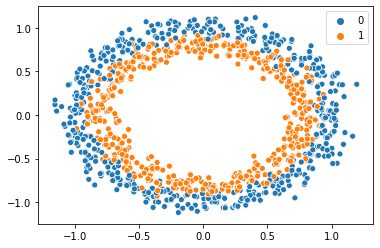

In [10]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

## Train conroller with low noise, and no Rotation

Training controller...



Done.


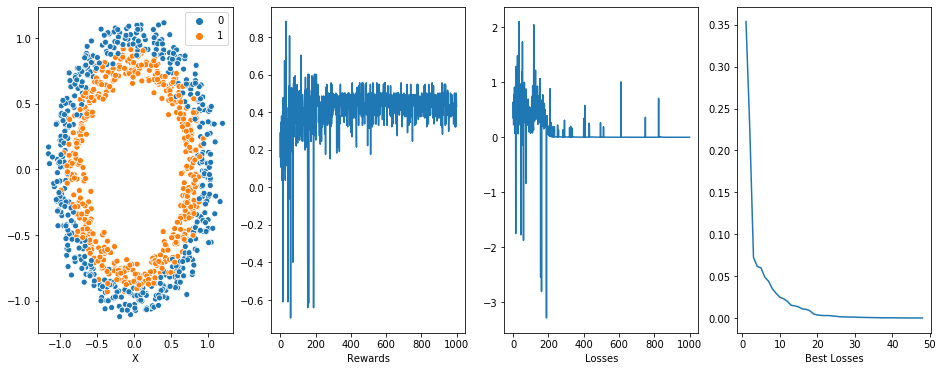

In [11]:
rewards, losses, saved_losses = train(controller, num_rollouts, dl_train, dl_dev)
plot_resuts(X, y, rewards, losses, saved_losses)

## Load trained controller, and Try it again on more complex dataset

In [12]:
dl_train, dl_dev, dl_test, X, y = load_dataset(dataset_name='circles', noise=0.1, rotate_angle=90)
transfer_controller = Controller()
# Load the controller
transfer_controller = load_controller(transfer_controller)

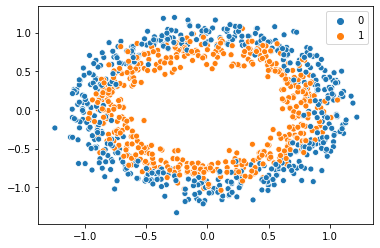

In [13]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

Training controller...



Done.


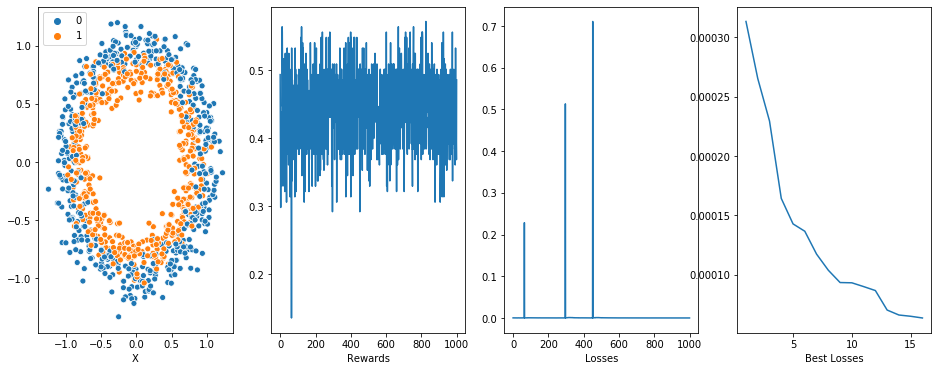

In [14]:
rewards, losses, saved_losses = train(transfer_controller, num_rollouts, dl_train, dl_dev)
plot_resuts(X, y, rewards, losses, saved_losses)

## Train new controller on the same complex dataset

Training controller...



Done.


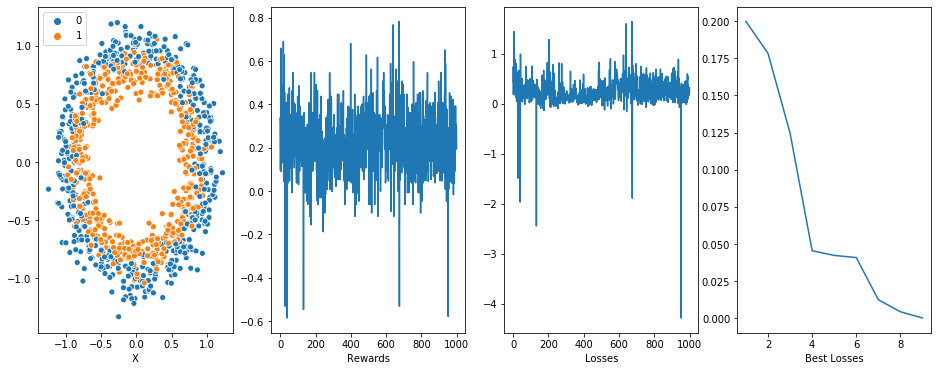

In [15]:
rewards, losses, saved_losses = train(Controller(), num_rollouts, dl_train, dl_dev)
plot_resuts(X, y, rewards, losses, saved_losses)